## 문자 단위 RNN (Char RNN)
- 입출력의 단위가 단어 레벨이 아니라 문자 레벨

In [381]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [382]:
%cd /content/drive/MyDrive/Colab Notebooks/딥러닝

/content/drive/MyDrive/Colab Notebooks/딥러닝


In [383]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

## 1. 훈련 데이터 전처리
- 입력 데이터와 레이블 데이터에 대해서 문자 집합을 만들겠습니다. -> 중복은 제외해야함! -> set

In [384]:
input_str = 'apple'
output_str = 'pple!'

char_vocab = sorted(list(set(input_str + output_str)))  # 중복 원소가 없는 문자 집합
vocab_size = len(char_vocab)
print("문자 집합의 크기 : ", vocab_size)
# char_socab = 'aple!'

문자 집합의 크기 :  5


입력은 one-hot 벡터를 사용할 것이기 때문에 **입력의 크기는 문자 집합의 크기**가 되어야 함

In [385]:
input_size = vocab_size
hidden_size = 5
output_size = 5
lr = 0.1   # learning rate

문자 집합에 레이블 부여

In [386]:
char_to_index = dict((c,i) for i, c in enumerate(char_vocab))
print(char_to_index)

{'!': 0, 'a': 1, 'e': 2, 'l': 3, 'p': 4}


In [387]:
index_to_char = dict()
for k,v in char_to_index.items() :
  index_to_char[v] = k
print(index_to_char)

{0: '!', 1: 'a', 2: 'e', 3: 'l', 4: 'p'}


입력 데이터와 레이블 데이터를 구성하는 문자들을 정수로 맵핑하기

In [388]:
x_data = [char_to_index[c] for c in input_str]
y_data = [char_to_index[c] for c in output_str]
print(x_data)
print(y_data)

[1, 4, 4, 3, 2]
[4, 4, 3, 2, 0]


NLP에서는 3차원 텐서가 기본이기 때문에, 배치 차원을 추가해준다 (※이미지는 4차원 데이터)

In [389]:
# 배치 차원 추가

x_data_ = [x_data]
y_data_ = [y_data]
print(x_data_)
print(y_data_)

[[1, 4, 4, 3, 2]]
[[4, 4, 3, 2, 0]]


In [390]:
# Pytorch에서의 텐서 연산인 unsqueeze(0)도 활용 가능
# squeeze -> 1차원 제거
# squeeze -> 1차원 생성
x_data_2 = torch.tensor(x_data).unsqueeze(0)
y_data_2 = torch.tensor(y_data).unsqueeze(0)
print(x_data_2.shape)
print(y_data_2.shape)

torch.Size([1, 5])
torch.Size([1, 5])


입력 시퀀스의 각 문자들을 one-hot 벡터로 변환!

In [391]:
# np.eye(n) -> n * n 사이즈의 단위 행렬 생성
x_one_hot = [np.eye(vocab_size)[x] for x in x_data_]
print(x_one_hot)

[array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.]])]


입력과 레이블 데이터를 텐서로 캐스팅

In [392]:
# FloatTensor, LongTensor -> 특정 텐서 타입의 생성자 호출
X = torch.FloatTensor(x_one_hot)
Y = torch.LongTensor(y_data_)

In [393]:
# 텐서의 shape 확인
print("학습 데이터의 크기 : {}".format(X.shape))
print("레이블 데이터의 크기 : {}".format(Y.shape))

학습 데이터의 크기 : torch.Size([1, 5, 5])
레이블 데이터의 크기 : torch.Size([1, 5])


## 모델 구현하기

In [394]:
class Net(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(Net, self).__init__()
    self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size, bias=True)  # 출력층

  def forward(self, x): # 구현한 RNN 셀과 FC 층을 연결하는 역할
    x, _ = self.rnn(x)
    x = self.fc(x)
    return x

In [395]:
# 인스턴스 생성 (네트워크를 인스턴스화)
net = Net(input_size, hidden_size, output_size)

In [396]:
outputs = net(X)
print(outputs.shape)
# 3차원 텐서

torch.Size([1, 5, 5])


(1,5,5)의 크기를 가지는 output tensor를 나중에 정확도 측정을 위해 2차원 텐서로 바꾸는 과정이 필요함

In [397]:
# 데이터를 보존하면서 차원을 줄이려면 reshape
# view -> 차원 축소
# -1 -> axis 하나를 줄임
print(outputs.view(-1, output_size).shape)

torch.Size([5, 5])


In [398]:
# 레이블 데이터 확인
# 2차원 -> 1차원으로 차원 축소
print(Y.shape)
print(Y.view(-1).shape) # 차원 축소

torch.Size([1, 5])
torch.Size([5])


Optimizer와 loss function(criterion)을 정의해보자

In [399]:
ciriterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

In [400]:
# Training code
epoch = 100
for i in range(epoch):
  optimizer.zero_grad()
  outputs = net(X)
  loss = ciriterion(outputs.view(-1, input_size), Y.view(-1)) # view() -> Batch dimension 제거를 위해
  loss.backward()  # 그래디언트 계산
  optimizer.step()

  # 프로그레스 바
  result = outputs.data.numpy().argmax(axis=2)  # output(5개의 값)에 대해서 가장 높은 값의 인덱스 선택! (숫자 형태)
  result_str = ''.join([index_to_char[c] for c in np.squeeze(result)]) # helper function을 호출하여 char를 str 형태로 변환
  print(i, "loss :", loss.item(), "prediction :", result, "label :", y_data_, "output_str :", result_str)

0 loss : 1.5342800617218018 prediction : [[4 4 0 0 4]] label : [[4, 4, 3, 2, 0]] output_str : pp!!p
1 loss : 1.2816122770309448 prediction : [[4 4 4 4 4]] label : [[4, 4, 3, 2, 0]] output_str : ppppp
2 loss : 1.1167980432510376 prediction : [[4 4 4 2 4]] label : [[4, 4, 3, 2, 0]] output_str : pppep
3 loss : 0.9555055499076843 prediction : [[4 4 3 2 4]] label : [[4, 4, 3, 2, 0]] output_str : pplep
4 loss : 0.7737993597984314 prediction : [[4 4 3 2 4]] label : [[4, 4, 3, 2, 0]] output_str : pplep
5 loss : 0.5967036485671997 prediction : [[4 4 3 2 0]] label : [[4, 4, 3, 2, 0]] output_str : pple!
6 loss : 0.45130395889282227 prediction : [[4 4 3 2 0]] label : [[4, 4, 3, 2, 0]] output_str : pple!
7 loss : 0.33422502875328064 prediction : [[4 4 3 2 0]] label : [[4, 4, 3, 2, 0]] output_str : pple!
8 loss : 0.2396467626094818 prediction : [[4 4 3 2 0]] label : [[4, 4, 3, 2, 0]] output_str : pple!
9 loss : 0.16951540112495422 prediction : [[4 4 3 2 0]] label : [[4, 4, 3, 2, 0]] output_str : ppl

## 문자 단위 RNN - with Sentence data

In [401]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

### 1. 훈련 데이터 전처리하기

In [402]:
sentence = ("if you want to build a ship, don't drum up people together to "
            "collect wood and don't assign them tasks and work, but rather "
            "teach them to long for the endless immensity of the sea.")

In [403]:
print(len(sentence))

180


In [404]:
char_set = sorted(list(set(sentence)))   # 문자 집합 생성
char_dic = {c: i for i, c in enumerate(char_set)}  # 각 문자에 정수 인코딩
print(char_dic) # !!문장에서는 공백도 하나의 원소로 대응!!

{' ': 0, "'": 1, ',': 2, '.': 3, 'a': 4, 'b': 5, 'c': 6, 'd': 7, 'e': 8, 'f': 9, 'g': 10, 'h': 11, 'i': 12, 'k': 13, 'l': 14, 'm': 15, 'n': 16, 'o': 17, 'p': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'w': 23, 'y': 24}


각 문자에 single-digit 레이블을 부여하였으며, 25의 크기를 가지는 문자 집합 완성

In [405]:
print('문자 집합의 크기 : {}'.format(len(char_dic)))

문자 집합의 크기 : 25


입력은 one-hot 벡터로 사용할 것이기 때문에 변환 과정 필요

In [406]:
# 문장 데이터이기 때문에 단위별로 끊어서 처리
# sentence_length라는 변수를 활용해보자
hidden_size = len(char_dic)  # hidden size -> 메모리 용량
sentence_length = 10  # -> 문장을 문자 10개 단위로 끊어서 전처리
lr = 0.1

In [407]:
# 데이터 구성
# x -> 인덱스 0~9번
# y -> 인덱스 1~10번
# x,y가 페어로 연결되어 있음
x_data = list()
y_data = list()

for i in range(0, len(sentence) - sentence_length):  # 170개
  x_str = sentence[i:i+sentence_length]
  y_str = sentence[i+1:i+sentence_length+1]
  print(i, x_str, '->', y_str)

  x_data.append([char_dic[c] for c in x_str])  # 입력 데이터를 single-digit화
  y_data.append([char_dic[c] for c in y_str])

0 if you wan -> f you want
1 f you want ->  you want 
2  you want  -> you want t
3 you want t -> ou want to
4 ou want to -> u want to 
5 u want to  ->  want to b
6  want to b -> want to bu
7 want to bu -> ant to bui
8 ant to bui -> nt to buil
9 nt to buil -> t to build
10 t to build ->  to build 
11  to build  -> to build a
12 to build a -> o build a 
13 o build a  ->  build a s
14  build a s -> build a sh
15 build a sh -> uild a shi
16 uild a shi -> ild a ship
17 ild a ship -> ld a ship,
18 ld a ship, -> d a ship, 
19 d a ship,  ->  a ship, d
20  a ship, d -> a ship, do
21 a ship, do ->  ship, don
22  ship, don -> ship, don'
23 ship, don' -> hip, don't
24 hip, don't -> ip, don't 
25 ip, don't  -> p, don't d
26 p, don't d -> , don't dr
27 , don't dr ->  don't dru
28  don't dru -> don't drum
29 don't drum -> on't drum 
30 on't drum  -> n't drum u
31 n't drum u -> 't drum up
32 't drum up -> t drum up 
33 t drum up  ->  drum up p
34  drum up p -> drum up pe
35 drum up pe -> rum up peo
36

#### 현재까지 총 170개로 구성된 데이터셋(x, y페어)를 생성하였음. 각 페어의 입력 데이터는 고유 정수로 인코딩이 된 상태

In [408]:
print(x_data[0])
print(y_data[0])

[12, 9, 0, 24, 17, 22, 0, 23, 4, 16]
[9, 0, 24, 17, 22, 0, 23, 4, 16, 21]


In [409]:
x_one_hot = [np.eye(len(char_dic))[x] for x in x_data] # one_hot 벡터 생성
X = torch.FloatTensor(x_one_hot)
Y = torch.LongTensor(y_data)   # Long -> 굉장히 큰 정수

In [410]:
print('학습 데이터의 크기 : {}'.format(X.shape))
print('레이블 데이터의 크기 : {}'.format(Y.shape))

학습 데이터의 크기 : torch.Size([170, 10, 25])
레이블 데이터의 크기 : torch.Size([170, 10])


In [411]:
print(Y[0])

tensor([ 9,  0, 24, 17, 22,  0, 23,  4, 16, 21])


## 모델 구현하기

In [412]:
class Net(nn.Module) :
  def __init__(self, input_dim, hidden_dim, layers):
    super(Net, self).__init__()
    self.rnn = nn.RNN(input_dim, hidden_dim, num_layers=layers, batch_first=True)
    self.fc = nn.Linear(hidden_dim, hidden_dim, bias=True)

  def forward(self, x):
    x, _ = self.rnn(x)
    x = self.fc(x)
    return x

In [413]:
dic_size = len(char_dic)

net = Net(dic_size, hidden_size, 2) # hidden layer가 2층짜리인 DRNN

In [414]:
# 손실 함수
criterion = nn.CrossEntropyLoss()
# 옵티마이저
optimizer = optim.Adam(net.parameters(), lr)

## 학습 진행하기

In [415]:
epoch = 100

for i in range(100):
  optimizer.zero_grad()
  outputs = net(X)  # (170, 10, 25) 크기를 가진 텐서를 매 epoch마다 모델의 입력으로 사용
  loss = criterion(outputs.view(-1, dic_size), Y.view(-1))
  loss.backward()
  optimizer.step()

  # 프로그레스 바
  # results의 텐서 크기는 (170,10)
  results = outputs.argmax(dim = 2)
  predict_str = str()
  for j, result in enumerate(results):
    if j == 0:   # 처음에는 예측 결과를 전부 가져오지만
      predict_str += ''.join([char_set[t] for t in result])
    else:  # 그 다음에는 마지막 글자만 반복 추가
      predict_str += char_set[result[-1]]

  print(predict_str)

ypyppyppyyyyyypyypyyyyyyppypyyyyyyyypyypyppyypyfypyypyyyyppyypypyyyypyypfyyyyyyyyyyyyyyyppyyypyypyyypyyyyyypppppypypypyyyyppyyyypyypyypyypypyplyrppypyyyyyyyyyppypyyypyypypyypyyyyy
lfuh ofhaahuhuhholhhuhuheouheofhuhuhuhueoffeanuhauhnouheouhhelhfhuahhuhnahuha uhuhuhuhhhbhuhonnfhhuhuhuhahuhahuhehuhuhuhuouhhahheahuouhhnuheaouha uheouhahuhueuhuhaahohueoufheouhah
 od od  td d  d   d d d  dd d dd od  d  d d  dd  d dl  d dd  d  d  d d  d  dd d  l  dd dl d  d    ldd d d d  d  d  ddl ddl d ld  l d  d  d  d d  dd   dddld  dd  d   d dd ld  d d l
  e  mh ege e e  htee h egh e hgh e egete e  hie e  gm e et e   e ee e  ge e h  ngh e h gmte e ete    h e em gh e e e e e eie e  e em ee e  ' ee et ege e e hiegh e hgh e et  etoeg
  s  tt  '    d  dt e    so e  tt e  d a  e   l  t  't e'ot  to eo t    d a the  'h et ngs   e  t   t        't et     led s  to eo tla  to to  tyt  't    n het   s ed   et  tt  '
n    t  nt e  t  t  t   e   to t  to t    t  t  tt nt  t  t  tont  t e  t     t  t  t   t  t e  to  

In [416]:
## Charseq 실습

sample = "if you want you"

# 딕셔너리 만들기
sen_set = sorted(list(set(sample)))
sen_dic = {c: i for i, c in enumerate(sen_set)}
dic_size = len(sen_dic)
print(sen_dic)

{' ': 0, 'a': 1, 'f': 2, 'i': 3, 'n': 4, 'o': 5, 't': 6, 'u': 7, 'w': 8, 'y': 9}


In [417]:
# 네트워크 하이퍼 파라미터 설정
hidden_size = dic_size # 은닉층 사이즈는 문자 집합 크기와 무관! 랜덤하게 사용가능
lr = 0.1

# 데이터 구성
idx= [ sen_dic[c] for c in sample]
x_data = [idx[:-1]]
print(f'x_data : {x_data}')
x_one_hot = [np.eye(dic_size)[x] for x in x_data]  # 원핫 벡터 인코딩
print(f'one-hot vector :{x_one_hot}')
y_data = [idx[1:]]
print(f'y_data : {y_data}')

x_data : [[3, 2, 0, 9, 5, 7, 0, 8, 1, 4, 6, 0, 9, 5]]
one-hot vector :[array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])]
y_data : [[2, 0, 9, 5, 7, 0, 8, 1, 4, 6, 0, 9, 5, 7]]


In [418]:
# tensor로 형변환(캐스팅)
X = torch.FloatTensor(x_one_hot)
Y = torch.LongTensor(y_data)

# RNN 선언
rnn = nn.RNN(dic_size, hidden_size, batch_first=True)

# Loss와 optimizer 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn.parameters(), lr)

In [419]:
# 간단한 학습 코드
epoch = 50

for i in range(epoch):
    optimizer.zero_grad()
    outputs, _ = rnn(X)
    loss = criterion(outputs.view(-1, dic_size), Y.view(-1))
    loss.backward()
    optimizer.step()

    # 결과
    results = outputs.data.numpy().argmax(axis=2)
    predict_str = ''.join([char_set[c] for c in np.squeeze(results)])
    print(i, "loss : ", loss.item(), "prediction : ", result, "label : ", y_data, "prediciton_str : ", result_str)

0 loss :  2.362180471420288 prediction :  tensor([16,  0, 21, 11,  8,  0, 20,  8,  4,  3]) label :  [[2, 0, 9, 5, 7, 0, 8, 1, 4, 6, 0, 9, 5, 7]] prediciton_str :  pple!
1 loss :  1.9960412979125977 prediction :  tensor([16,  0, 21, 11,  8,  0, 20,  8,  4,  3]) label :  [[2, 0, 9, 5, 7, 0, 8, 1, 4, 6, 0, 9, 5, 7]] prediciton_str :  pple!
2 loss :  1.7594960927963257 prediction :  tensor([16,  0, 21, 11,  8,  0, 20,  8,  4,  3]) label :  [[2, 0, 9, 5, 7, 0, 8, 1, 4, 6, 0, 9, 5, 7]] prediciton_str :  pple!
3 loss :  1.6085045337677002 prediction :  tensor([16,  0, 21, 11,  8,  0, 20,  8,  4,  3]) label :  [[2, 0, 9, 5, 7, 0, 8, 1, 4, 6, 0, 9, 5, 7]] prediciton_str :  pple!
4 loss :  1.5035427808761597 prediction :  tensor([16,  0, 21, 11,  8,  0, 20,  8,  4,  3]) label :  [[2, 0, 9, 5, 7, 0, 8, 1, 4, 6, 0, 9, 5, 7]] prediciton_str :  pple!
5 loss :  1.4069143533706665 prediction :  tensor([16,  0, 21, 11,  8,  0, 20,  8,  4,  3]) label :  [[2, 0, 9, 5, 7, 0, 8, 1, 4, 6, 0, 9, 5, 7]] predi

## Char RNN으로 이름 분류하기
데이터 주소 : http://download.pytorch.org/tutorial/data.zip

In [420]:
from google.colab import drive
import sys
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [421]:
%cd /content/drive/MyDrive/Colab Notebooks/딥러닝

/content/drive/MyDrive/Colab Notebooks/딥러닝


- data2/names/[language].txt이 18개 존재
- 각 파일에는 한 줄에 하나의 이름이 적혀있음 -> 로마자로 되어 있음
- UNICODE -> ASCII

In [422]:
!pwd

/content/drive/MyDrive/Colab Notebooks/딥러닝


In [423]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path) :
  return glob.glob(path)  # glob -> 파일명 호출

print(findFiles('./data2/names/*.txt'))

['./data2/names/Spanish.txt', './data2/names/Korean.txt', './data2/names/Portuguese.txt', './data2/names/Japanese.txt', './data2/names/Italian.txt', './data2/names/French.txt', './data2/names/Scottish.txt', './data2/names/Arabic.txt', './data2/names/Russian.txt', './data2/names/Greek.txt', './data2/names/English.txt', './data2/names/Czech.txt', './data2/names/Chinese.txt', './data2/names/Dutch.txt', './data2/names/Polish.txt', './data2/names/Irish.txt', './data2/names/German.txt', './data2/names/Vietnamese.txt']


In [424]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,:'"   # 문자 집합 = 아스키코드 + 특수문자
# 57개 -> 소문자(26) + 대문자(26) + 특수문자(5개)
n_letters = len(all_letters)  # 문자 집합의 크기

# 유니코드 문자열을 ASCII로 변환
def unicode2Ascii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn'
      and c in all_letters    # 'Mn'이 아니고 and 문자 집합에 있다면!
  )

In [425]:
# 함수가 잘 작동하는지 확인
print(unicode2Ascii('Ślusàrski'))

Slusarski


In [426]:
# 이름 데이터 파일을 읽고 줄 단위로 분리 -> 데이터셋 구축!!

def readLines(filename):
  lines = open(filename, encoding='utf-8').read().strip().split('\n')
  return [unicode2Ascii(line) for line in lines]

In [427]:
category_lines = dict()
all_categories = list()

for filename in findFiles('./data2/names/*.txt'):
  category = os.path.splitext(os.path.basename(filename))[0]  # 파일을 불러온 다음 확장자만 떼고 리스트 생성
  all_categories.append(category)
  lines = readLines(filename)  # 파일을 읽고 줄 단위로 분리
  category_lines[category] = lines  # key(category) -> 언어명 / value(lines) -> 그 언어에서 사용하는 이름들

n_categories = len(all_categories)
print(n_categories)
print(all_categories)
print(category_lines)
print(category_lines['Korean'])
print(category_lines['Chinese'])
print(category_lines['Japanese'])

18
['Spanish', 'Korean', 'Portuguese', 'Japanese', 'Italian', 'French', 'Scottish', 'Arabic', 'Russian', 'Greek', 'English', 'Czech', 'Chinese', 'Dutch', 'Polish', 'Irish', 'German', 'Vietnamese']
{'Spanish': ['Abana', 'Abano', 'Abarca', 'Abaroa', 'Abascal', 'Abasolo', 'Abel', 'Abello', 'Aberquero', 'Abreu', 'Acosta', 'Agramunt', 'Aiza', 'Alamilla', 'Albert', 'Albuquerque', 'Aldana', 'Alfaro', 'Alvarado', 'Alvarez', 'Alves', 'Amador', 'Andreu', 'Antunez', 'Aqua', 'Aquino', 'Araujo', 'Araullo', 'Araya', 'Arce', 'Arechavaleta', 'Arena', 'Aritza', 'Armando', 'Arreola', 'Arriola', 'Asis', 'Asturias', 'Avana', 'Azarola', 'Banderas', 'Barros', 'Basurto', 'Bautista', 'Bello', 'Belmonte', 'Bengochea', 'Benitez', 'Bermudez', 'Blanco', 'Blanxart', 'Bolivar', 'Bonaventura', 'Bosque', 'Bustillo', 'Busto', 'Bustos', 'Cabello', 'Cabrera', 'Campo', 'Campos', 'Capello', 'Cardona', 'Caro', 'Casales', 'Castell', 'Castellano', 'Castillion', 'Castillo', 'Castro', 'Chavarria', 'Chavez', 'Colon', 'Costa', '

- 각 category(언어)를 line(이름)에 매핑하는 dict인 category_lines 생성

In [428]:
print(category_lines['Korean'][-3:])

['Youn', 'Yu', 'Yun']


In [429]:
print(category_lines['Japanese'][50:56])

['Chiba', 'Chikamatsu', 'Chikanatsu', 'Chino', 'Chishu', 'Choshi']


## 이름을 텐서로 변경
- 하나의 문자를 표현하기 위해 one-hot 벡터를 사용
- 단어를 만들기 위해 one-hot 벡터들을 2차원 매트릭스로 만들어주어야 한다.

In [430]:
import torch

# all_letters로 문자의 위치(인덱스) 찾기 => 'a' -> 0
def letterToIndex(letter) :
  return all_letters.find(letter)

# 검증을 위해서 문자 하나를 one-hot vector(1 * 문자 수) 텐서로 변환하는 함수
def letterToTensor(letter):
  t = torch.zeros(1, n_letters)    # 1 * n_letters 사이즈를 0으로 다 채워넣기
  t[0][letterToIndex(letter)] = 1  # 문자의 위치(인덱스)를 찾아서 1로 바꿔주기(원핫인코딩)

  return t

In [431]:
# 이름을 <line_length * 1 * n_letters>로 바꿔주어야 함
# line_length * letterToTensor(= 1 * n_letters)
def nameToTensor(name):
  tensor = torch.zeros(len(name), 1, n_letters)
  for n, letter in enumerate(name):  # enumerate -> 인덱스와 값을 반환해주는 함수
    tensor[n][0][letterToIndex(letter)] = 1
  return tensor

In [432]:
print(letterToTensor('J'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


In [433]:
print(letterToTensor('K'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


In [434]:
print(nameToTensor('Chiba'))

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

In [435]:
print(nameToTensor('Chiba').size())
# 문자 집합의 크기(all_letters의 크기) -> 57 -> 소문자(26) + 대문자(26) + 특수문자(5개)

torch.Size([5, 1, 57])


## 모델 구현

In [436]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size

    # input_size -> 입력층, hidden_size -> 은닉층, output_size = 출력층
    self.i2h = nn.Linear(input_size ,hidden_size)  # M * N
    self.h2h = nn.Linear(hidden_size, hidden_size) # N * N => (M * N) *(N * N) = (M * N)
    self.h2o = nn.Linear(hidden_size, output_size) # N * P => (M * N) *(N * P) = (M * P)
    self.softmax = nn.LogSoftmax(dim=1)  # M * P

  def forward(self, input, hidden):
    hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
    output = self.h2o(hidden)
    output = self.softmax(output)

    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)

In [437]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [438]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output_l, next_hidden = rnn(input, hidden)
print(output_l)

tensor([[-2.8285, -2.8578, -2.8498, -3.0394, -2.8204, -2.9489, -2.9237, -3.0162,
         -2.7505, -3.0714, -2.9223, -2.7044, -2.8539, -2.9266, -2.8055, -2.9248,
         -2.9341, -2.9264]], grad_fn=<LogSoftmaxBackward0>)


In [439]:
input = nameToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output_n, next_hidden = rnn(input[0], hidden)
print(output_n)

tensor([[-2.8285, -2.8578, -2.8498, -3.0394, -2.8204, -2.9489, -2.9237, -3.0162,
         -2.7505, -3.0714, -2.9223, -2.7044, -2.8539, -2.9266, -2.8055, -2.9248,
         -2.9341, -2.9264]], grad_fn=<LogSoftmaxBackward0>)


## 학습 준비
- Helper function을 선언
  - 주의! 네트워크에는 softmax layer가 들어가 있다면 -> crossentropy를 사용하면 안 됨!
  - FC layer의 마지막 출력층에 softmax 함수가 적용된다면 crossendtropy를 쓸 수 없다 -> NLL(Negative Log Likelihood) loss를 써야함

In [440]:
# Helper function
def categoryFromOutput(output):
  top_n, top_i = output.topk(1)
  category_i = top_i[0].item()  # 텐서에서 정수값으로 변경

  return all_categories[category_i], category_i

print(categoryFromOutput(output_l))

('Czech', 11)


In [441]:
import random

def randomChoice(l) :

  return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
  category = randomChoice(all_categories)
  name = randomChoice(category_lines[category])  # category_lines -> 딕셔너리 형태
  category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
  name_tensor = nameToTensor(name)

  return category, name, category_tensor, name_tensor
  # category -> y 데이터

for _ in range(10):
  category, name, category_tensor, name_tensor = randomTrainingExample()
  print('category =', category, '/ name =', name)

category = English / name = Lambert
category = Korean / name = Yeon
category = Korean / name = Chu
category = English / name = Caldwell
category = German / name = Wehner
category = Scottish / name = Stevenson
category = Russian / name = Glazenap
category = Vietnamese / name = Kieu
category = Czech / name = Pfeifer
category = English / name = Kennedy


## 모델 학습
- nn.CELoss => nn.NLLLoss + Softmax()

In [442]:
critierion = nn.NLLLoss()

In [443]:
lr = 0.005     # 학습률이 너무 높으면 과적합이 발생할 수 있음

In [444]:
def train(category_tensor, name_tensor):
  hidden = rnn.initHidden()

  rnn.zero_grad()

  for i in range(name_tensor.size()[0]):
    output, hidden = rnn(name_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn.parameters():
      p.data.add_(p.grad.data, alpha=-lr)  # _접미사 -> 바꿔치기(in-place) 연산

    return output, loss.item()

In [445]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# 시각화를 위한 loss 그래프
current_loss = 0
all_losses = list()

# Runtime 계산을 위한 시간 체크 함수
def timeSince(since):
  now = time.time()
  s = now - since
  m = math.floor(s / 60)
  s -= m * 60

  return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
  category, name, category_tensor, name_tensor = randomTrainingExample()
  output,loss = train(category_tensor, name_tensor)
  current_loss += loss

  if iter % print_every == 0:
    g, g_i = categoryFromOutput(output)
    correct = '✓' if g == category else '✗ (%s)' % category
    print('%d %d%% (%s) %.4f %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, g, correct))
    # %d -> 정수 / %s -> 문자열 / %.4f -> 정수 소수점 넷째 자리까지

  if iter % plot_every == 0:
    all_losses.append(current_loss / plot_every)
    current_loss = 0

5000 5% (0m 4s) 2.9659 Greek ✗ (Vietnamese)
10000 10% (0m 7s) 3.0049 Portuguese ✗ (Greek)
15000 15% (0m 11s) 2.8913 Chinese ✗ (Spanish)
20000 20% (0m 15s) 3.2705 Polish ✗ (Spanish)
25000 25% (0m 19s) 2.5264 Vietnamese ✓
30000 30% (0m 22s) 3.5684 Polish ✗ (French)
35000 35% (0m 26s) 2.3287 Polish ✗ (English)
40000 40% (0m 30s) 3.1701 Scottish ✗ (Italian)
45000 45% (0m 34s) 2.4657 Dutch ✗ (Irish)
50000 50% (0m 37s) 2.6910 French ✗ (English)
55000 55% (0m 41s) 1.7850 French ✗ (Vietnamese)
60000 60% (0m 45s) 2.4802 Portuguese ✗ (Irish)
65000 65% (0m 48s) 3.2168 Korean ✗ (French)
70000 70% (0m 52s) 3.0745 Greek ✗ (Portuguese)
75000 75% (0m 56s) 2.0202 Korean ✗ (Russian)
80000 80% (1m 0s) 2.7209 Spanish ✗ (Greek)
85000 85% (1m 3s) 3.2137 French ✗ (Vietnamese)
90000 90% (1m 7s) 3.5481 Vietnamese ✗ (Dutch)
95000 95% (1m 11s) 2.7622 Arabic ✗ (Italian)
100000 100% (1m 14s) 2.8537 French ✗ (Scottish)


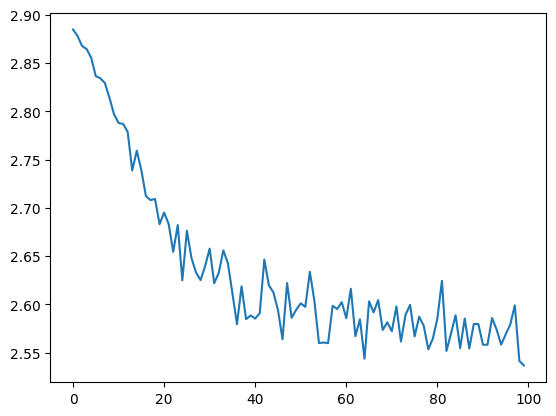

In [446]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

##  Confusion Matrix (분류 평가 지표)

- tp, tn, fp, fn

- Row가 label, Column이 prediction
- 실제 언어가 네트워크에서 어떤 언어로 추론이 되는지를 확인하기 위한 혼란, 혼돈 행렬
- 가시적으로 보기 위함

In [447]:
confusion = torch.zeros(n_categories, n_categories) # 18 * 18 사이즈를 0으로 초기화
n_conf = 10000

def evaluate(name_tensor):

  hidden = rnn.initHidden()

  for i in range(name_tensor.size()[0]):
    output, hidden = rnn(name_tensor[i], hidden)

  return output

<ipython-input-448-425c9309f1de>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-448-425c9309f1de>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


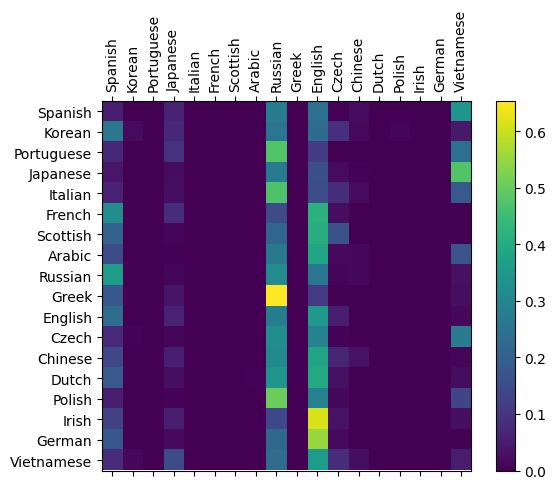

In [448]:
for i in range(n_conf):
  category, name, category_tensor, name_tensor = randomTrainingExample()
  output = evaluate(name_tensor)
  g, g_i = categoryFromOutput(output)
  category_i = all_categories.index(category)
  confusion[category_i][g_i] += 1

for i in range(n_categories):
  confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [449]:
def predict(input_line, n_predictions=3):
  print('\n > %s' % input_line)

  with torch.no_grad():
    output = evaluate(nameToTensor(input_line))

    # Topk prediction
    topv, topi = output.topk(n_predictions, 1, True)
    predictions = list()

    for i in range(n_predictions):
        value = topv[0][i].item()
        category_index = topi[0][i].item()
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

predict('Jackson')


 > Jackson
(-2.53) Czech
(-2.58) Russian
(-2.59) English


In [450]:
predict('Chiba')


 > Chiba
(-2.15) Vietnamese
(-2.36) Russian
(-2.44) Spanish


In [451]:
predict('Choi')


 > Choi
(-2.45) Czech
(-2.47) Russian
(-2.52) English


# 문자 단위 RNN으로 이름 생성하기
- 한번에 한 글자씩 출력

In [452]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

# 문자 집합 만들기
all_letters = string.ascii_letters + ".,:'-"
n_letters = len(all_letters) + 1   # 1을 더해주는 이유? -> EOS (End of Sentence)


## Helper Function 만드는 과정
def findFiles(path):
  return glob.glob(path)

# UNICODE -> ASCII
def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn'
      and c in all_letters
  )

# 파일을 읽고 줄 단위로 분리해서 이름을 Ascii로
def readLines(filename):
  with open(filename, encoding='utf-8') as some_file :
    return [unicodeToAscii(name.strip()) for name in some_file]

# 각 언어권의 이름 목록인 딕셔너리 생성
category_names = dict()
all_categories = list()

for filename in findFiles('./data2/names/*.txt'):
  category = os.path.splitext(os.path.basename(filename))[0]
  all_categories.append(category)
  names = readLines(filename)
  category_names[category] = names

n_c = len(all_categories)
print(n_c)

18


In [453]:
print(category_names)

{'Spanish': ['Abana', 'Abano', 'Abarca', 'Abaroa', 'Abascal', 'Abasolo', 'Abel', 'Abello', 'Aberquero', 'Abreu', 'Acosta', 'Agramunt', 'Aiza', 'Alamilla', 'Albert', 'Albuquerque', 'Aldana', 'Alfaro', 'Alvarado', 'Alvarez', 'Alves', 'Amador', 'Andreu', 'Antunez', 'Aqua', 'Aquino', 'Araujo', 'Araullo', 'Araya', 'Arce', 'Arechavaleta', 'Arena', 'Aritza', 'Armando', 'Arreola', 'Arriola', 'Asis', 'Asturias', 'Avana', 'Azarola', 'Banderas', 'Barros', 'Basurto', 'Bautista', 'Bello', 'Belmonte', 'Bengochea', 'Benitez', 'Bermudez', 'Blanco', 'Blanxart', 'Bolivar', 'Bonaventura', 'Bosque', 'Bustillo', 'Busto', 'Bustos', 'Cabello', 'Cabrera', 'Campo', 'Campos', 'Capello', 'Cardona', 'Caro', 'Casales', 'Castell', 'Castellano', 'Castillion', 'Castillo', 'Castro', 'Chavarria', 'Chavez', 'Colon', 'Costa', 'Crespo', 'Cruz', 'Cuellar', 'Cuevas', "D'cruz", "D'cruze", 'Delacruz', 'Delafuente', 'Delbosque', 'Deleon', 'Delgado', 'Delolmo', 'Desantigo', 'Diaz', 'Dominguez', 'Duarte', 'Durante', 'Echevarria'

## 네트워크 구성
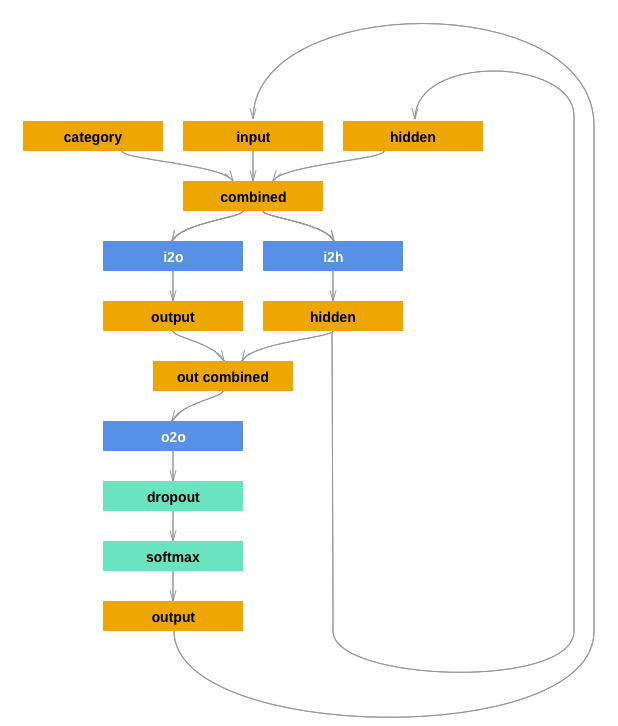

In [454]:
import torch

# all_letters로 문자의 위치(인덱스) 찾기 => 'a' -> 0
def letterToIndex(letter) :
  return all_letters.find(letter)

# 검증을 위해서 문자 하나를 one-hot vector(1 * 문자 수) 텐서로 변환하는 함수
def letterToTensor(letter):
  t = torch.zeros(1, n_letters)    # 1 * n_letters 사이즈를 0으로 다 채워넣기
  t[0][letterToIndex(letter)] = 1  # 문자의 위치(인덱스)를 찾아서 1로 바꿔주기(원핫인코딩)

  return t

# 한 줄(이름)을 <line_length x 1 x n_letters>,
# 또는 One-Hot 문자 벡터의 Array로 변경
def lineToTensor(line):
  t = torch.zeros(len(line), 1, n_letters)
  for li, letter in enumerate(line):
    t[li][0][letterToIndex(letter)] = 1
  return t

In [455]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        # input to  hidden linear layer
        # n_categories + input_size + hidden_size = combined (사진 참조)
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        # input to output linear layer
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        # output to output linear layer
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

## 학습 준비

In [456]:
import random

# 목록에서 무작위 아이템 반환
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# 임의의 카테고리와 그 카테고리에서의 이름 pair 얻기
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [457]:
# Category를 원핫 벡터 인코딩 시키기 위한 함수
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# input을 원핫인코딩 시키기 위한 함수
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# 목표를 위한 두번째 문자 부터 마지막(EOS)까지의 LongTensor
# def targetTensor(line):
#     letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
#     letter_indexes.append(n_letters - 1) # EOS
#     return torch.LongTensor(letter_indexes)

def targetTensor(line):
    letter_indexes = [all_letters.find(letter) for letter in line]
    # 모든 값이 0 이상이 되도록 변경
    letter_indexes = [max(0, idx) for idx in letter_indexes]
    tensor = torch.LongTensor(letter_indexes)
    return tensor

In [458]:
# 임의 언어에서, category, input, target tensor를 리턴해주는 함수
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    # print(f'category_tensor : {category_tensor}')
    # print(f'input_line_tensor : {input_line_tensor}')
    # print(f'target_line_tensor : {target_line_tensor}')
    return category_tensor, input_line_tensor, target_line_tensor

In [459]:
randomTrainingExample()

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]]),
 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

## 네트워크 학습

In [460]:
criterion = nn.NLLLoss()

lr = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    # torch.squeeze()
    # x = torch.rand(1, 1, 20, 200)
    # x = x.squeeze()  [1, 2, 20, 200] -> [20, 200]

    # torch.unsqueeze()
    # x = torch.rand(3, 20, 200)
    # x = x.unsqueeze(dim=1) [3, 20, 200] ->
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = torch.Tensor([0])

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-lr)

    return output, loss.item() / input_line_tensor.size(0)

In [461]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [462]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 17s (5000 5%) 2.1702
0m 34s (10000 10%) 1.7648
0m 53s (15000 15%) 1.1809
1m 10s (20000 20%) 0.9429
1m 27s (25000 25%) 1.2469
1m 45s (30000 30%) 0.6299
2m 3s (35000 35%) 0.1651
2m 20s (40000 40%) 0.0858
2m 37s (45000 45%) 0.1038
2m 55s (50000 50%) 1.2294
3m 14s (55000 55%) 0.1465
3m 30s (60000 60%) 0.6257
3m 48s (65000 65%) 0.0321
4m 7s (70000 70%) 0.0428
4m 25s (75000 75%) 1.8661
4m 42s (80000 80%) 0.1345
5m 0s (85000 85%) 0.6313
5m 18s (90000 90%) 0.4763
5m 35s (95000 95%) 0.1581
5m 52s (100000 100%) 0.0258


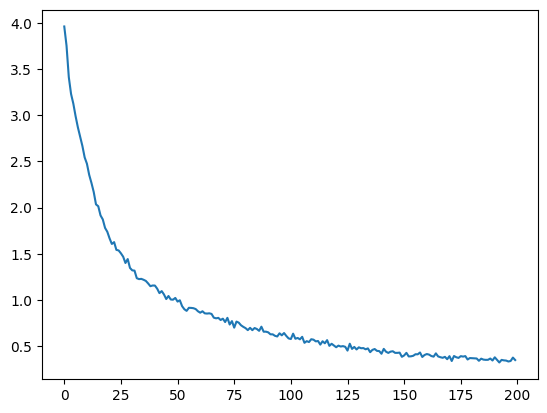

In [463]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)
plt.show()

## 네트워크 샘플링
- 샘플링을 위해서 네트워크에 하나의 글자를 주고 다음 문자를 물어보기 -> 다음 문자로 전달 -> EOS 토큰까지 반복
1. 입력 카테고리(언어), 시작 문자, 비어 있는 은닉 상태를 위한 Tensor 생성
2. 시작 문자로 output_name 문자열 생성
3. 최대 출력 길이까지
  - 현재 문자를 네트워크에 전달
  - 가장 높은 출력에서 다음 문자와 다음 은닉 상태를 얻기
  - 만일 문자가 EOS면, 멈추기
  - 만약 일반적인 문자라면, output_name에 추가하고 계속하기
4. 마지막 이름을 반환하기

In [464]:
max_length = 20

# 카테고리와 시작 문자로부터 샘플링 하기
def sample(category, start_letter='A'):
    with torch.no_grad():  # 샘플링에서 히스토리를 추적할 필요 없음
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# 하나의 카테고리와 여러 시작 문자들로 여러 개의 샘플 얻기
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

RRoorrrrrrrrrrrrrrrIr
UJpppppMMgggnnnnnnnnn
SSjjjjyyyyyyyyyyyyyyy
GGccrrrrrrrrrrrj.OChh
EFiiiiiiiiiiiieeeeeee
RRllllBE.iiiiiiiiiiii
SSq-ttttttqVooyffffkk
PP-aaaaaahhhhhhrXmmmm
AAxAAAfCiii-':BQCbbbb
CCKUjjF,:Hzzzzzzzzzzz
HHzzzzzzzzzVTBUVC:E.H
IJE'kkkkkkkkkkkklllll
